In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'CS229/Project/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/CS229/Project


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from util import load_dataset
from util import place_bets
from util import evaluate_bets
from custom_loss import LogisticRegression
from custom_loss import custom_loss

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', None)

# Setting up the data

In [3]:
# Training
x_train = load_dataset("Load_Data/x_train.csv", intercept=True)
y_train = load_dataset("Load_Data/y_train.csv").to_numpy().flatten()

# Validation
x_val = load_dataset("Load_Data/x_val.csv", intercept=True)
y_val = load_dataset("Load_Data/y_val.csv").to_numpy().flatten()

# Test
x_test = load_dataset("Load_Data/x_test.csv", intercept=True)
y_test = load_dataset("Load_Data/y_test.csv").to_numpy().flatten()

In [4]:
# Odds data
odds_home_tr = x_train['Odds_Home'].to_numpy()
odds_away_tr = x_train['Odds_Away'].to_numpy()
odds_home_val = x_val['Odds_Home'].to_numpy()
odds_away_val = x_val['Odds_Away'].to_numpy()
odds_home_test = x_test['Odds_Home'].to_numpy()
odds_away_test = x_test['Odds_Away'].to_numpy()


# Converting everything into python arrays
x_train = x_train.to_numpy()
x_val = x_val.to_numpy()
x_test = x_test.to_numpy()

In [5]:
# Setting up logistic regression model

lr_vec = [2e-6, 1.5e-6, 1e-6]
max_profit_tr = []
max_profit_val = []
models = []
profit_iter_matrix = []
profit_history_matrix = []

for lr in lr_vec:
  
  # Initializing and training the model
  model = LogisticRegression(step_size=lr, max_iter=500, verbose=True, debug=True)
  model.fit(x_train, y_train, odds_home_tr, odds_away_tr)

  # Generating predictions and calculating profit
  y_val_hat = model.predict(x_val)
  y_val_profit = custom_loss(y_val, y_val_hat, odds_home_val, odds_away_val)

  # Calculating profit for every iteration
  profit_history = model.predict_debug(x_val, y_val, odds_home_val, odds_away_val)
  profit_history_matrix.append(profit_history)

  # Appending profit in training and validation
  max_profit_tr.append(model.loss)
  max_profit_val.append(y_val_profit)
  models.append(model)
  profit_iter_matrix.append(model.iteration_profit)

print("-"*40)
print(lr_vec)
print(max_profit_tr)
print(max_profit_val)

Streaming output truncated to the last 5000 lines.
----------------------------------------
Iteration 287
Norm is 0.02117476260192312
Profit is 8863.101
Difference is 18.183999999999287
Number of games predicted win home: 80552
Total number of games: 211591
----------------------------------------
Iteration 288
Norm is 0.02118029555514478
Profit is 8887.356
Difference is 24.2549999999992
Number of games predicted win home: 80587
Total number of games: 211591
----------------------------------------
Iteration 289
Norm is 0.021185890082769318
Profit is 8944.350999999999
Difference is 56.99499999999898
Number of games predicted win home: 80612
Total number of games: 211591
----------------------------------------
Iteration 290
Norm is 0.021191923840428215
Profit is 8943.947999999997
Difference is 0.40300000000206637
Number of games predicted win home: 80632
Total number of games: 211591
----------------------------------------
Iteration 291
Norm is 0.021198211493536838
Profit is 8955.707


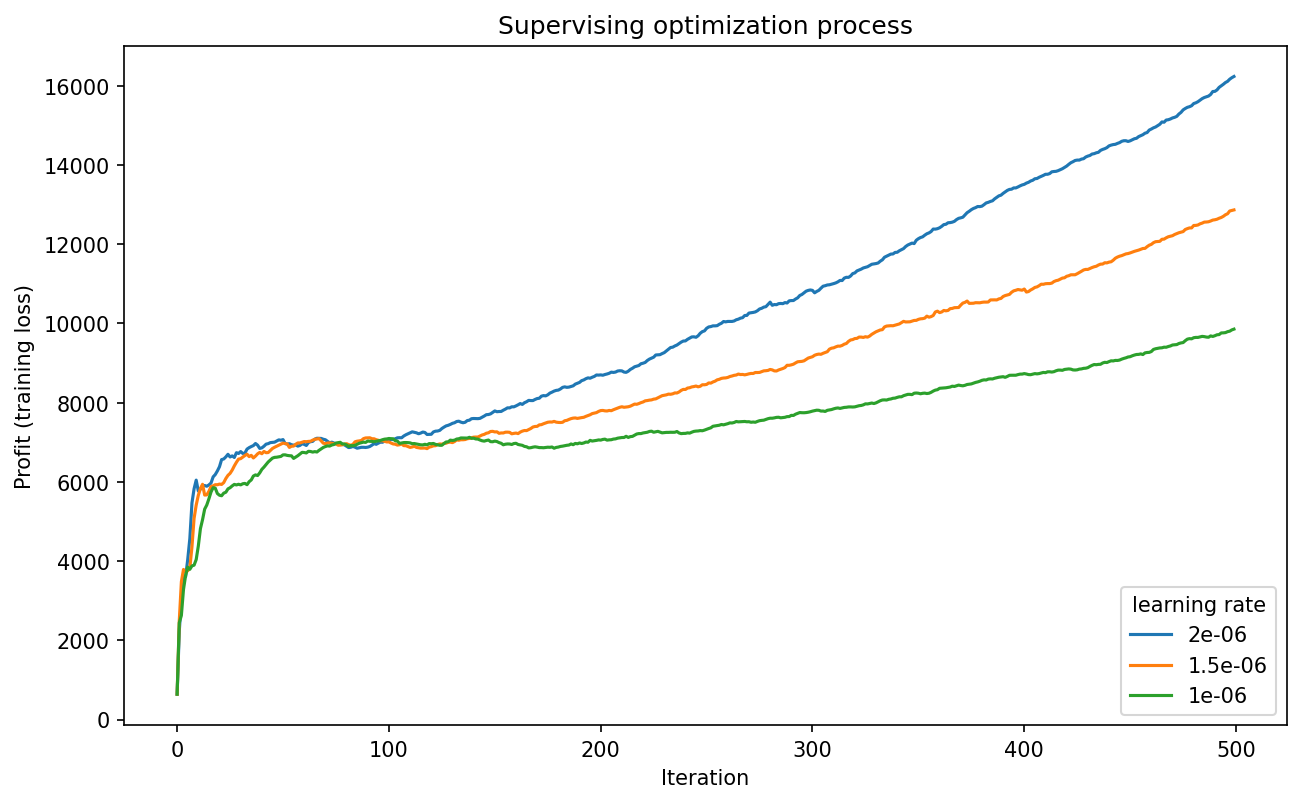

In [6]:
# Setting up figure size and resolution
plt.figure(num=1, figsize=(10, 6), dpi=150, facecolor='w', edgecolor='k')

# Plotting training loss through iterations
for i in range(len(profit_iter_matrix)):
  plt.plot(profit_iter_matrix[i], label=lr_vec[i])  
plt.ylabel("Profit (training loss)")
plt.xlabel("Iteration")
plt.title(f"Supervising optimization process")
plt.legend(title='learning rate', loc='lower right')
plt.show()

Text(0.5, 0.98, 'Validation vs. training accuracy')

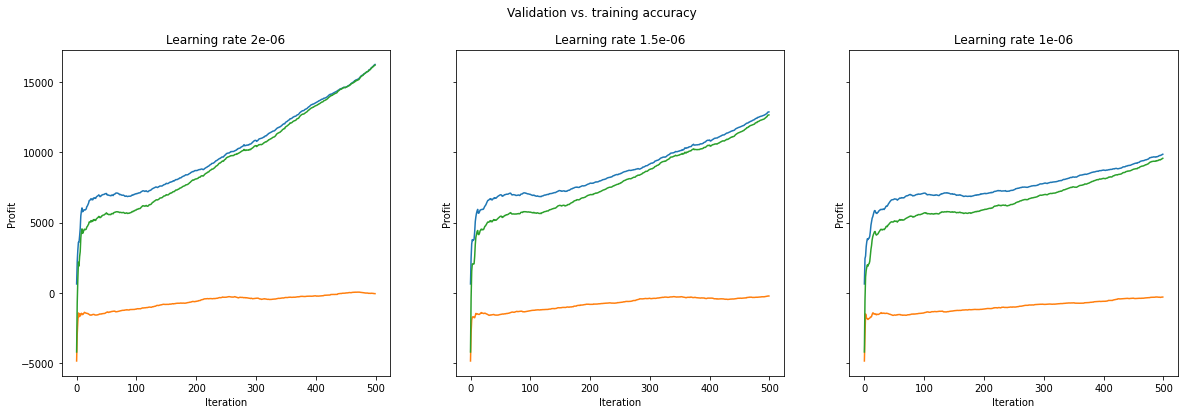

In [7]:
# Initialize (1,n) subplots
fig, axs = plt.subplots(1, len(lr_vec), sharey=True, figsize=(20,6))

# Plot each subplot
for i in range(len(lr_vec)):
  train_acc = np.asarray(profit_iter_matrix[i])
  val_acc = np.asarray(profit_history_matrix[i])
  diff = np.abs(train_acc) - np.abs(val_acc)

  axs[i].plot(train_acc)
  axs[i].plot(val_acc)
  axs[i].plot(diff)

  axs[i].set_xlabel("Iteration")
  axs[i].set_ylabel("Profit")
  axs[i].set_title(f"Learning rate {lr_vec[i]}")

fig.suptitle("Validation vs. training accuracy")



## Exploring accuracy and profitability of this model 

In [8]:
# Obtain best model
best_model = models[np.argmax(max_profit_val)]

In [9]:
# Review accuracy on training data
y_pred_tr = best_model.predict(x_train)

acc_tr = np.mean(y_pred_tr == y_train)

print(f"The accuracy in the training data is {100*acc_tr:.2f}%")

The accuracy in the training data is 69.99%


In [10]:
# Review accuracy on validation data
y_pred_val = best_model.predict(x_val)

acc_val = np.mean(y_pred_val == y_val)

print(f"The accuracy in the training data is {100*acc_val:.2f}%")

The accuracy in the training data is 71.56%


In [11]:
# Profitability in training data
profit_tr = custom_loss(y_train, y_pred_tr, odds_home_tr, odds_away_tr)
print(f"The model achieves a profit of ${profit_tr} in the training sample")

The model achieves a profit of $16236.467 in the training sample


In [12]:
# Profitability in validation data
profit_val = custom_loss(y_val, y_pred_val, odds_home_val, odds_away_val)
print(f"The model achieves a profit of ${profit_val} in the training sample")

The model achieves a profit of $-46.06099999999998 in the training sample


## Allowing for No-Bet option, maximizing expected profit given probabilities

In [13]:
# Profit on training set

# Instead of looking at hard predictions, lest look at soft predicted probabilities
prob_train = best_model.predict_proba(x_train)
prob_tr_mat = np.zeros((prob_train.shape[0], 2))
prob_tr_mat[:, 0] = 1 - prob_train
prob_tr_mat[:, 1] = prob_train

# Making bet decision, using place_bets function from util
bets_train = place_bets(prob_tr_mat, odds_home_tr, odds_away_tr)

# # Evaluating profit in the training sample
profit_train = evaluate_bets(bets_train, odds_home_tr, odds_away_tr, y_train)

print(f"The model achieves a profit of ${profit_train.sum():.2f} in the training sample")

The model achieves a profit of $10550.95 in the training sample


In [14]:
# Profit on validation set

# Instead of looking at hard predictions, lest look at soft predicted probabilities
prob_val = best_model.predict_proba(x_val)
prob_val_mat = np.zeros((prob_val.shape[0], 2))
prob_val_mat[:, 0] = 1 - prob_val
prob_val_mat[:, 1] = prob_val

# Making bet decision, using place_bets function from util
bets_val = place_bets(prob_val_mat, odds_home_val, odds_away_val)

# # Evaluating profit in the training sample
profit_val = evaluate_bets(bets_val, odds_home_val, odds_away_val, y_val)

print(f"The model achieves a profit of ${profit_val.sum():.2f} in the validations sample")

The model achieves a profit of $-604.92 in the validations sample


## Looking at test set results

Forcing model to place a bet

In [15]:
# Accuracy of the model on test data
y_pred_test = best_model.predict(x_test)

acc_test = np.mean(y_pred_test == y_test)

print(f"The accuracy in the training data is {100*acc_test:.2f}%")

The accuracy in the training data is 69.71%


In [20]:
# Profitability in validation data
profit_test = custom_loss(y_test, y_pred_test, odds_home_test, odds_away_test)
print(f"The model achieves a profit of ${profit_test} in the test sample. This is a return of {100*profit_test / len(y_pred_test):.2f}%")

The model achieves a profit of $2186.495 in the test sample. This is a return of 5.28%


Allowing model to decide not to place a bet

In [16]:
# Looking at profitability on test data

# Instead of looking at hard predictions, lest look at soft predicted probabilities
prob_test = best_model.predict_proba(x_test)
prob_test_mat = np.zeros((prob_test.shape[0], 2))
prob_test_mat[:, 0] = 1 - prob_test
prob_test_mat[:, 1] = prob_test

# Making bet decision, using place_bets function from util
bets_test = place_bets(prob_test_mat, odds_home_test, odds_away_test)

# # Evaluating profit in the training sample
profit_test = evaluate_bets(bets_test, odds_home_test, odds_away_test, y_test)

print(f"The model achieves a profit of ${profit_test.sum():.2f} in the test sample")

The model achieves a profit of $-299.26 in the test sample
